# 1. Load Data

**Target Variables of Interest:**
</br>**MTrend** - Monthly price %change with 5 classes
</br>**MTrend2** - Monthly price %change with 3 classes


In [ ]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model and performance
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold, GridSearchCV # tuning hyperparameters
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler

# Ensembled sampling
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from xgboost import XGBRFClassifier


sns.set()
%matplotlib inline

In [ ]:
df_sp_raw = pd.read_csv('sp500_final_monthly.csv')

In [ ]:
df_sp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                899 non-null    object 
 1   PriceValue          899 non-null    float64
 2   key                 899 non-null    object 
 3   ShillerPERatio      899 non-null    float64
 4   Earnings            899 non-null    float64
 5   TreasuryRate        899 non-null    float64
 6   Unemployment        899 non-null    float64
 7   CPI                 899 non-null    float64
 8   USRealGDP           899 non-null    float64
 9   PriceDiff           899 non-null    float64
 10  ShillerPERatioDiff  899 non-null    float64
 11  EarningsDiff        899 non-null    float64
 12  TreasuryRateDiff    899 non-null    float64
 13  UnemploymentDiff    899 non-null    float64
 14  CPIDiff             899 non-null    float64
 15  USRealGDPDiff       899 non-null    float64
 16  MTrend  

# 2. Missing Data

In [ ]:
df_sp_raw.isnull().sum()

Date                  0
PriceValue            0
key                   0
ShillerPERatio        0
Earnings              0
TreasuryRate          0
Unemployment          0
CPI                   0
USRealGDP             0
PriceDiff             0
ShillerPERatioDiff    0
EarningsDiff          0
TreasuryRateDiff      0
UnemploymentDiff      0
CPIDiff               0
USRealGDPDiff         0
MTrend                0
dtype: int64

<Axes: >

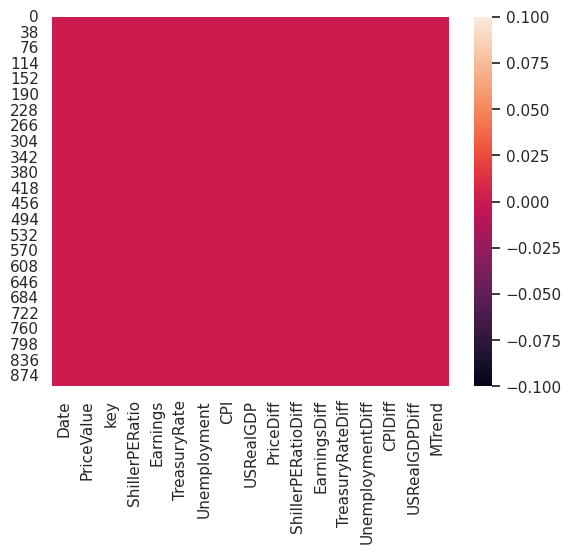

In [ ]:
# clearly shows red which means there is no null value on our data
sns.heatmap(df_sp_raw.isnull())

# 3. Duplicates

In [ ]:
df_sp_raw.duplicated().sum()

0

# 4. Trend by Class

In [ ]:
df_sp_raw['MTrend'].unique()

array(['Bearish', 'Neutral', 'Bullish'], dtype=object)

In [ ]:
df_sp_raw[['MTrend']].head()

,MTrend
0,Bearish
1,Neutral
2,Bullish
3,Bullish
4,Bullish


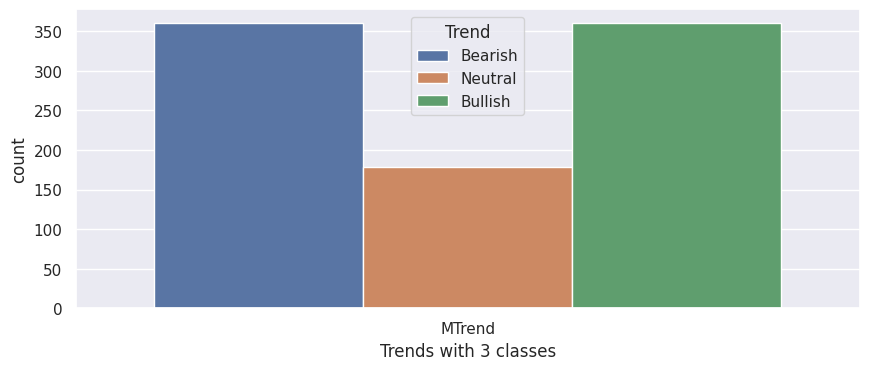

Bearish    360
Bullish    360
Neutral    179
Name: MTrend, dtype: int64

In [ ]:
figure, axis = plt.subplots(figsize=(10, 5))
figure.tight_layout(pad=5.0)

df_trends_3classes = df_sp_raw[['MTrend']]
df = df_trends_3classes.melt(var_name='Trends with 3 classes', value_name='Trend')
sns.countplot(x='Trends with 3 classes', hue='Trend', data=df, ax=axis)

plt.show()

display(df_sp_raw.MTrend.value_counts())

In [ ]:
df_sp_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                899 non-null    object 
 1   PriceValue          899 non-null    float64
 2   key                 899 non-null    object 
 3   ShillerPERatio      899 non-null    float64
 4   Earnings            899 non-null    float64
 5   TreasuryRate        899 non-null    float64
 6   Unemployment        899 non-null    float64
 7   CPI                 899 non-null    float64
 8   USRealGDP           899 non-null    float64
 9   PriceDiff           899 non-null    float64
 10  ShillerPERatioDiff  899 non-null    float64
 11  EarningsDiff        899 non-null    float64
 12  TreasuryRateDiff    899 non-null    float64
 13  UnemploymentDiff    899 non-null    float64
 14  CPIDiff             899 non-null    float64
 15  USRealGDPDiff       899 non-null    float64
 16  MTrend  

In [ ]:
# identifying numerical and non-numerica variables
numerical_vars = []
non_numerical_vars = []

for column in df_sp_raw.columns:
  if df_sp_raw[column].dtype == 'float64':
    numerical_vars.append(column)
  else:
    non_numerical_vars.append(column)

print("Numberical variables: ", numerical_vars)
print("Non-numerical variables: ", non_numerical_vars)

numerical_df = df_sp_raw[numerical_vars].copy()

numerical_df.info()

Numberical variables:  ['PriceValue', 'ShillerPERatio', 'Earnings', 'TreasuryRate', 'Unemployment', 'CPI', 'USRealGDP', 'PriceDiff', 'ShillerPERatioDiff', 'EarningsDiff', 'TreasuryRateDiff', 'UnemploymentDiff', 'CPIDiff', 'USRealGDPDiff']
Non-numerical variables:  ['Date', 'key', 'MTrend']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PriceValue          899 non-null    float64
 1   ShillerPERatio      899 non-null    float64
 2   Earnings            899 non-null    float64
 3   TreasuryRate        899 non-null    float64
 4   Unemployment        899 non-null    float64
 5   CPI                 899 non-null    float64
 6   USRealGDP           899 non-null    float64
 7   PriceDiff           899 non-null    float64
 8   ShillerPERatioDiff  899 non-null    float64
 9   EarningsDiff        899 non-null    float64
 10  TreasuryRat

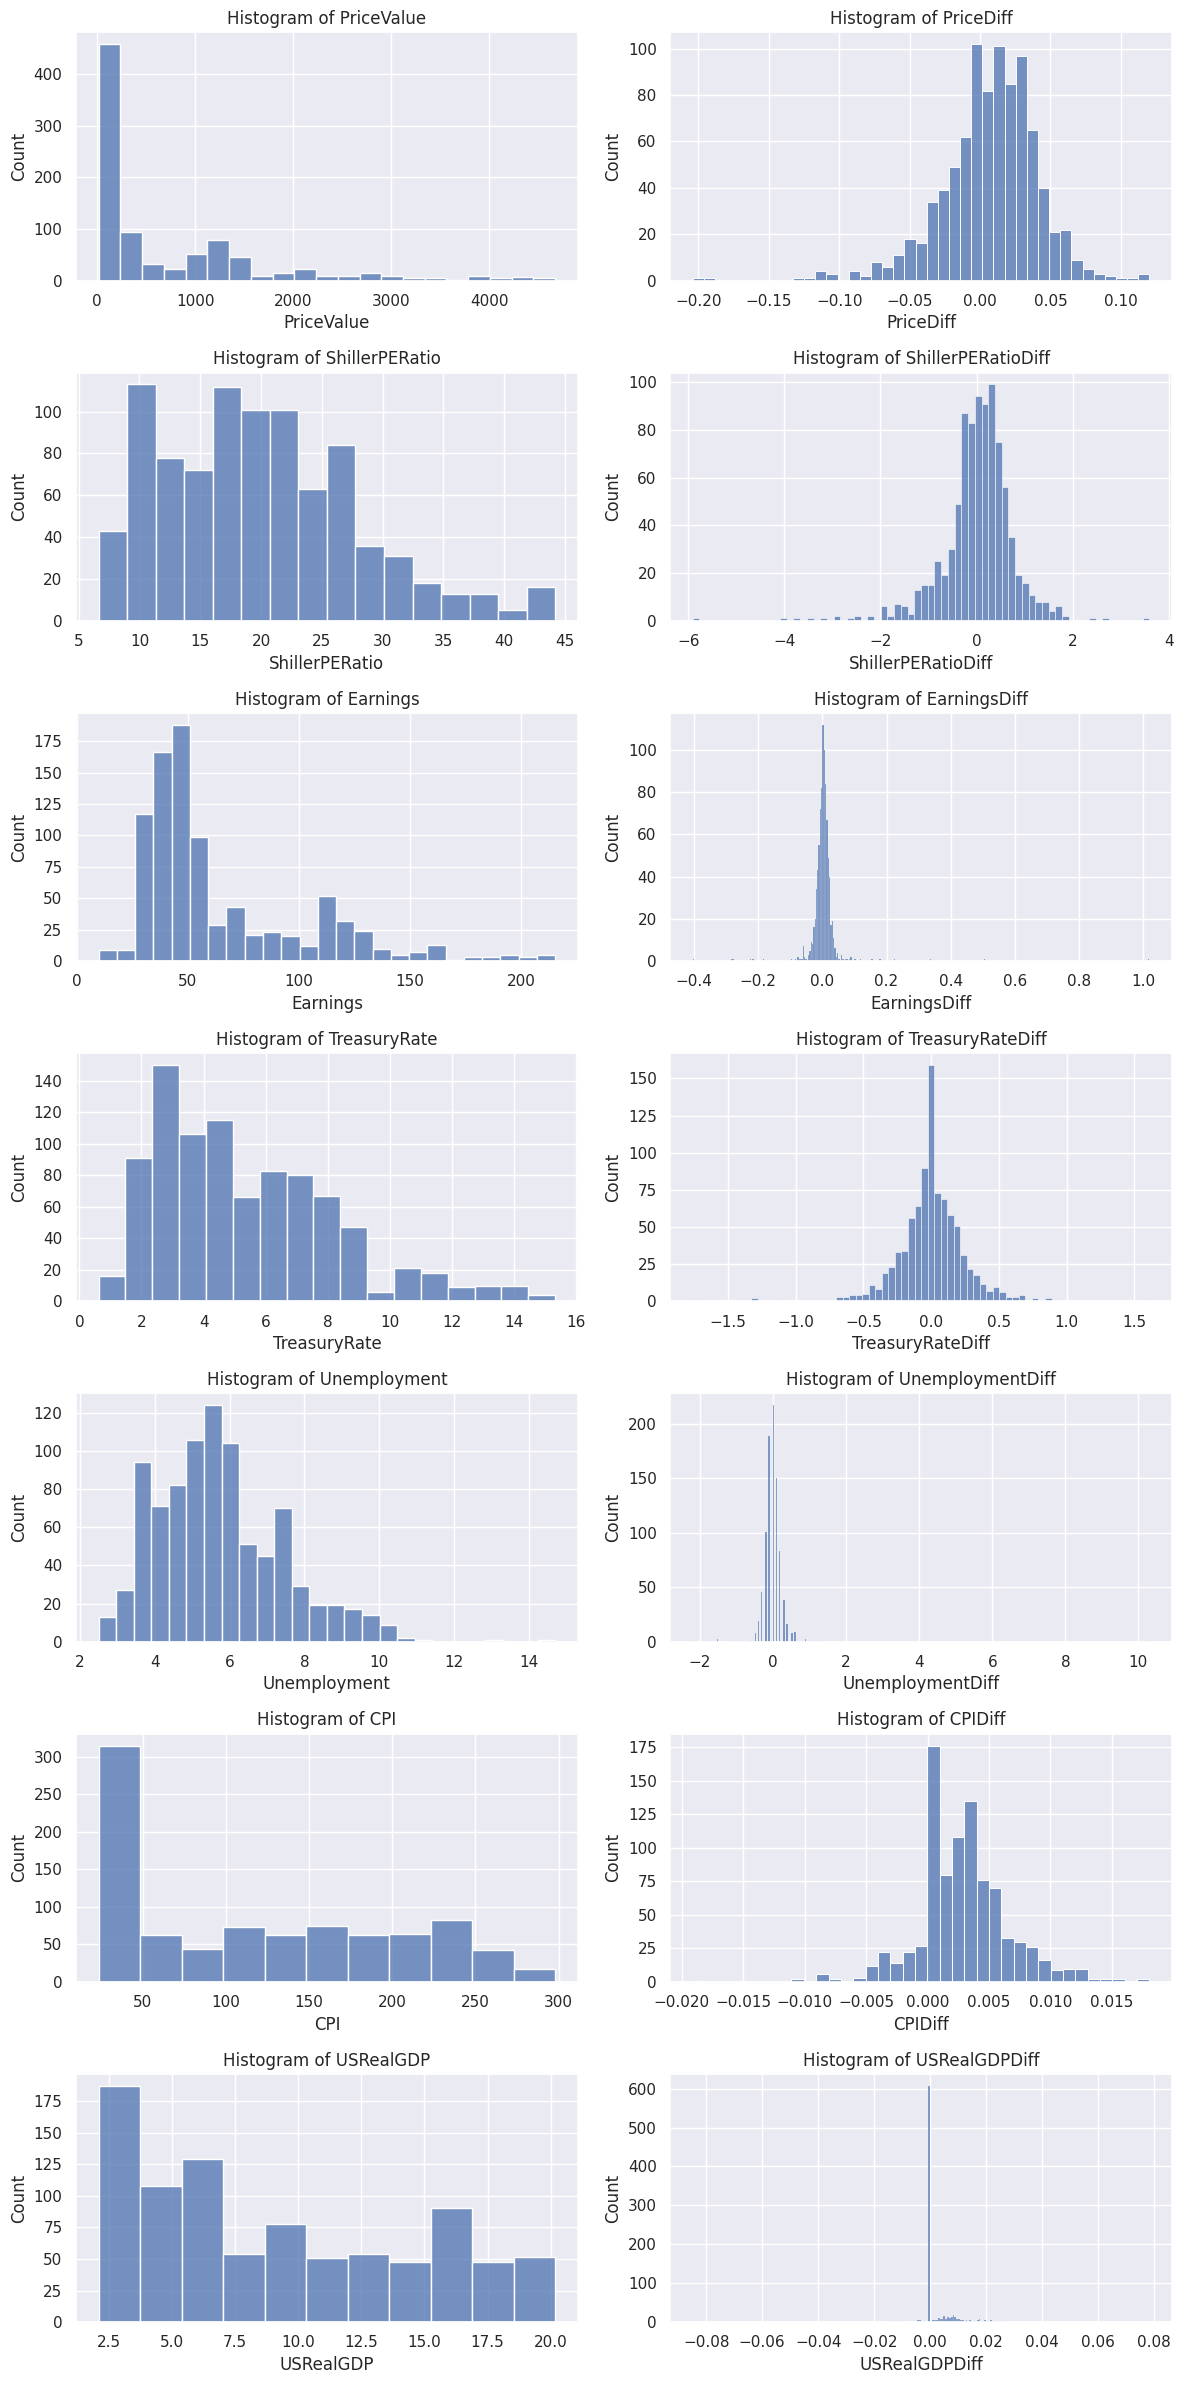

In [ ]:
var_order = [
    'PriceValue', 'PriceDiff', 'ShillerPERatio', 'ShillerPERatioDiff',
    'Earnings', 'EarningsDiff', 'TreasuryRate', 'TreasuryRateDiff',
    'Unemployment', 'UnemploymentDiff', 'CPI', 'CPIDiff',
    'USRealGDP', 'USRealGDPDiff'
]

numerical_df = numerical_df.reindex(columns=var_order)

# Create subplots with 2 columns
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

# Reshape axes to a 1-dimensional array
axes = axes.flatten()

# Display histograms for each pair of variables
for i, column in enumerate(numerical_df.columns):
    sns.histplot(numerical_df[column], ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')

# Adjust the layout and spacing of subplots
fig.tight_layout()

# Show the plot
plt.show()

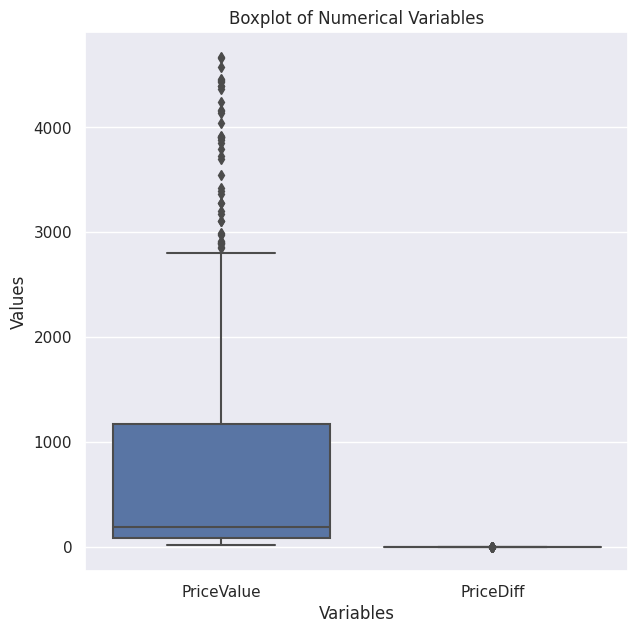

In [ ]:
plt.figure(figsize=(7, 7))

# Create a boxplot using seaborn
ax = sns.boxplot(data=numerical_df[['PriceValue', 'PriceDiff']])

# Set the title and labels
plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

plt.show()

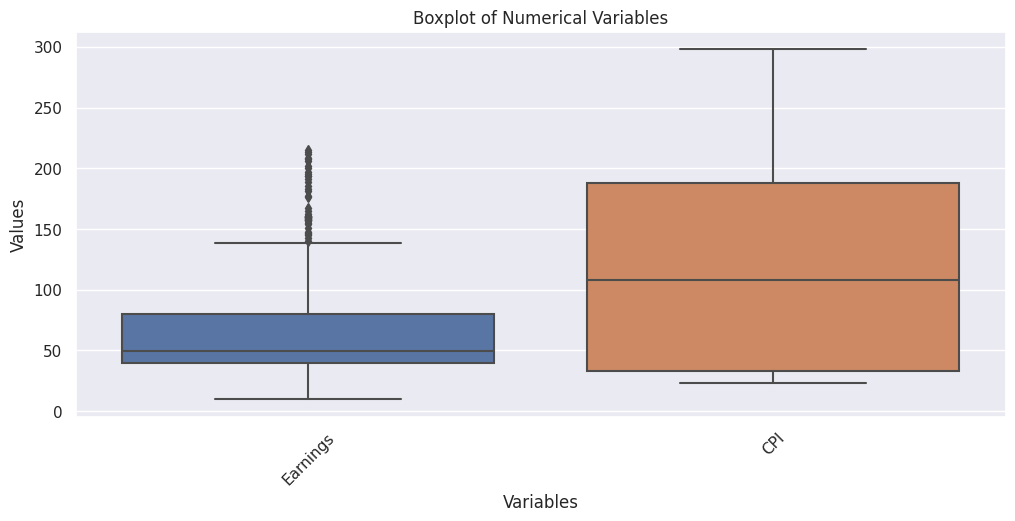

In [ ]:

plt.figure(figsize=(12,5))
# Create a boxplot using seaborn
sns.boxplot(data=numerical_df[
    [
        'Earnings', 'CPI'
        ]
    ])

# Set the title and labels
plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
fig.tight_layout()

# Display the plot
plt.show()

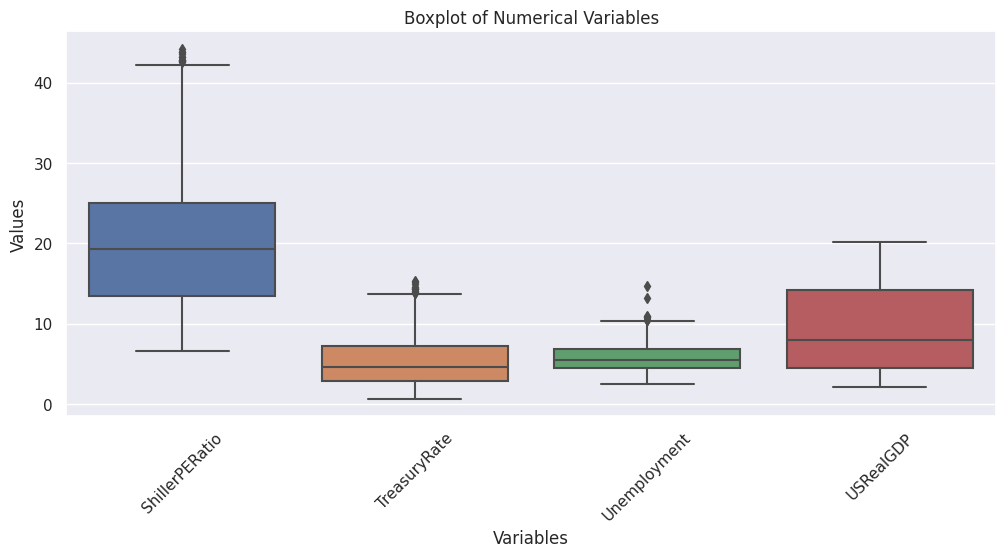

In [ ]:
plt.figure(figsize=(12,5))
# Create a boxplot using seaborn
sns.boxplot(data=numerical_df[
    [
        'ShillerPERatio',  'TreasuryRate',
        'Unemployment', 'USRealGDP'
        ]
    ])

# Set the title and labels
plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
fig.tight_layout()

# Display the plot
plt.show()

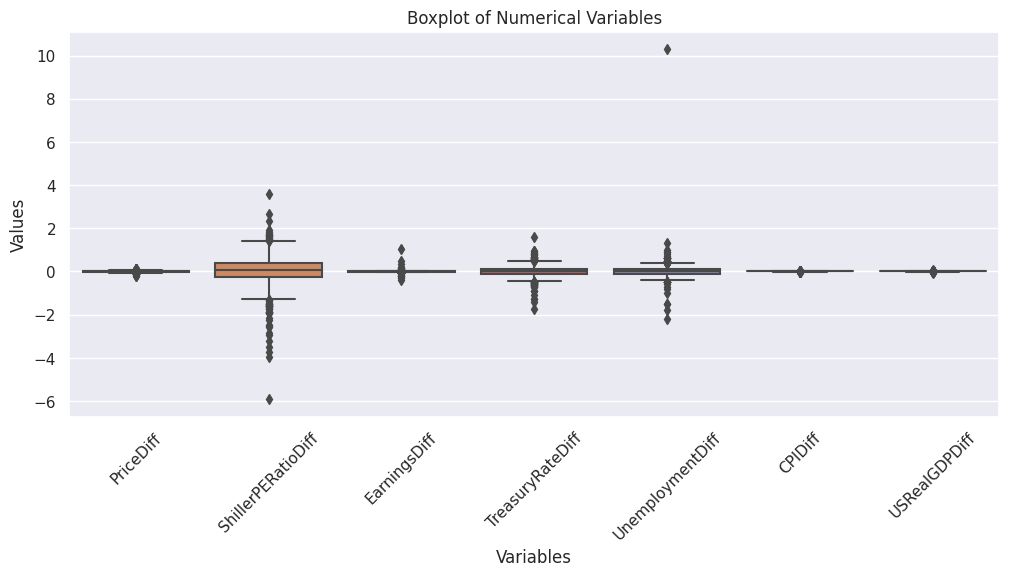

In [ ]:
plt.figure(figsize=(12,5))
# Create a boxplot using seaborn
sns.boxplot(data=numerical_df[
    [
        'PriceDiff',  'ShillerPERatioDiff',
        'EarningsDiff', 'TreasuryRateDiff',
        'UnemploymentDiff', 'CPIDiff',
        'USRealGDPDiff'
        ]
    ])

# Set the title and labels
plt.title('Boxplot of Numerical Variables')
plt.xlabel('Variables')
plt.ylabel('Values')

# Rotate the x-axis labels for better visibility
plt.xticks(rotation=45)
fig.tight_layout()

# Display the plot
plt.show()

# 5. Data by Period

In [ ]:
df_sp_raw.tail()

,Date,PriceValue,key,ShillerPERatio,Earnings,TreasuryRate,Unemployment,CPI,USRealGDP,PriceDiff,ShillerPERatioDiff,EarningsDiff,TreasuryRateDiff,UnemploymentDiff,CPIDiff,USRealGDPDiff,MTrend
894,2022-08-01,4158.56,2022-08,30.70,193.39,2.90,3.7,296.17,19.90,0.063100,1.70,-0.008714,0.00,0.2,-0.000371,0.000000,Bullish
895,2022-09-01,3850.52,2022-09,28.23,191.21,3.52,3.5,296.81,20.05,-0.074074,-2.47,-0.011273,0.62,-0.2,0.002161,0.007538,Bearish
896,2022-10-01,3726.05,2022-10,27.08,185.58,3.98,3.7,298.01,20.05,-0.032326,-1.15,-0.029444,0.46,0.2,0.004043,0.000000,Bearish
897,2022-11-01,3917.49,2022-11,28.38,180.90,3.89,3.6,297.71,20.05,0.051379,1.30,-0.025218,-0.09,-0.1,-0.001007,0.000000,Bullish
898,2022-12-01,3912.38,2022-12,28.32,176.57,3.62,3.5,296.80,20.18,-0.001304,-0.06,-0.023936,-0.27,-0.1,-0.003057,0.006484,Bearish


In [ ]:
# normality
# feature imptce
# correlation
# outliers


In [ ]:
##### SELECT THE VARIABLES HERE ACCORDINGLY #####
df_monthly = df_sp_raw[['Date', 'PriceValue', 'Earnings', 'ShillerPERatio', 'TreasuryRate', 'Unemployment', 'CPI', 'USRealGDP', 'MTrend']]

df_monthly_diff = df_sp_raw[['Date','PriceDiff','EarningsDiff', 'ShillerPERatioDiff','TreasuryRateDiff','UnemploymentDiff','CPIDiff','USRealGDPDiff','MTrend']]


## Correlations by period

<ipython-input-20-c3c27dcd97f8>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr1 = df_monthly.corr()
<ipython-input-20-c3c27dcd97f8>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr2 = df_monthly_diff.corr()


Text(0.5, 1.0, 'Monthly (Diff)')

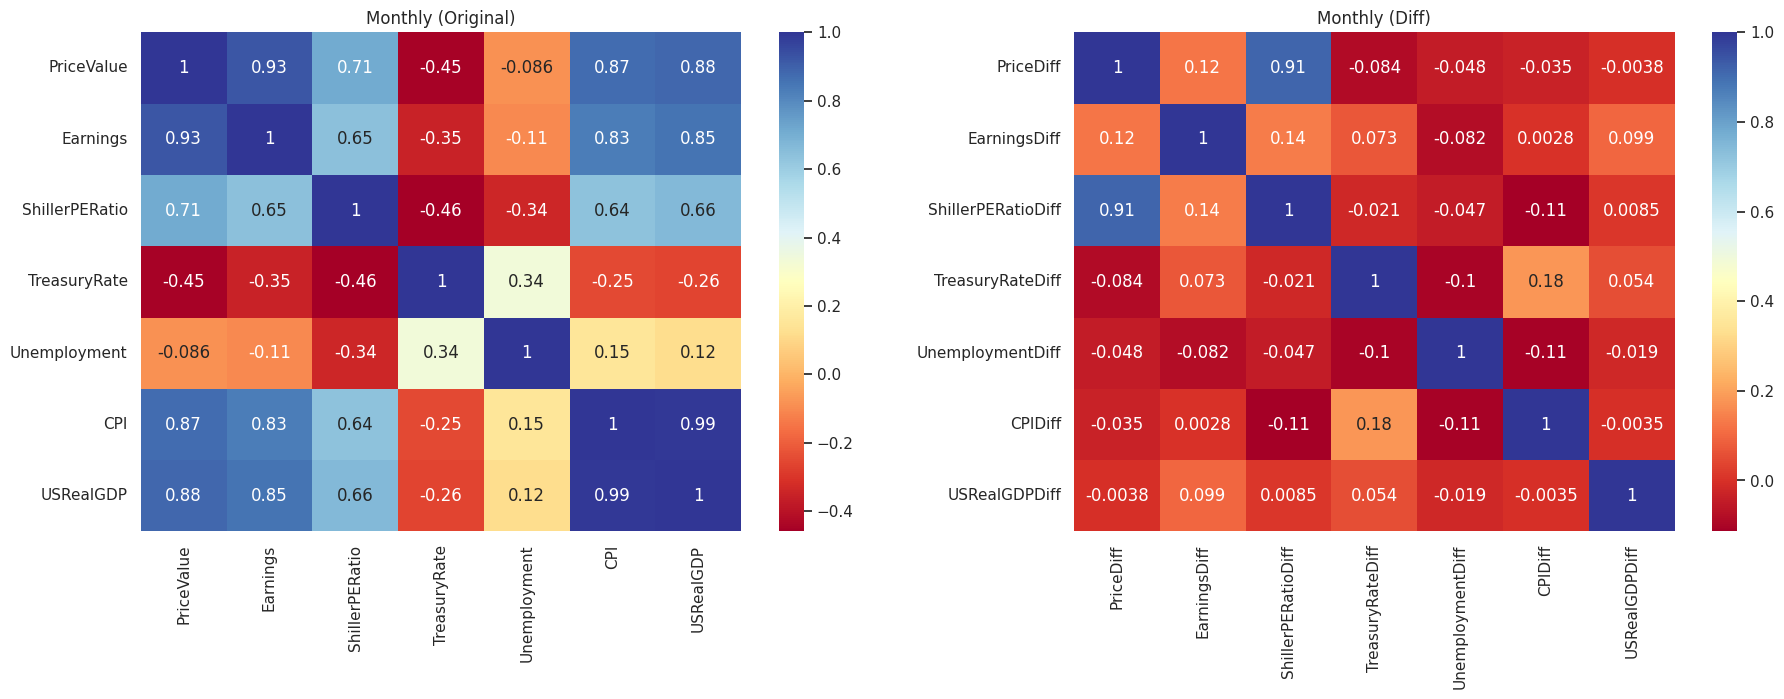

In [ ]:
figure, axis = plt.subplots(1, 2, figsize = (20, 8))
figure.tight_layout(pad = 8.0)

corr1 = df_monthly.corr()
sns.heatmap(corr1, annot = True, ax = axis[0], cmap='RdYlBu')
axis[0].set_title("Monthly (Original)")

corr2 = df_monthly_diff.corr()
sns.heatmap(corr2, annot = True, ax = axis[1], cmap='RdYlBu')
axis[1].set_title("Monthly (Diff)")


## Boxplot by Class and Period

### 3 Classes


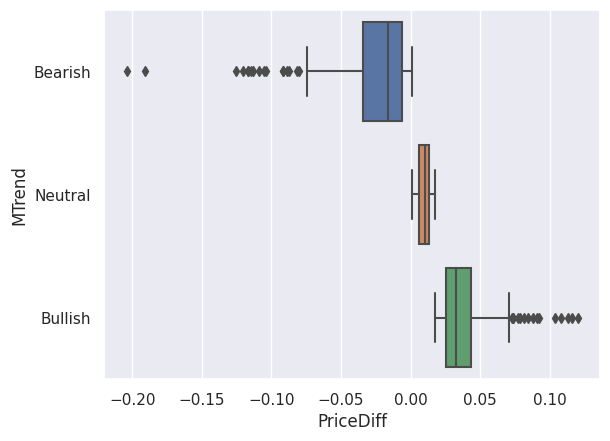

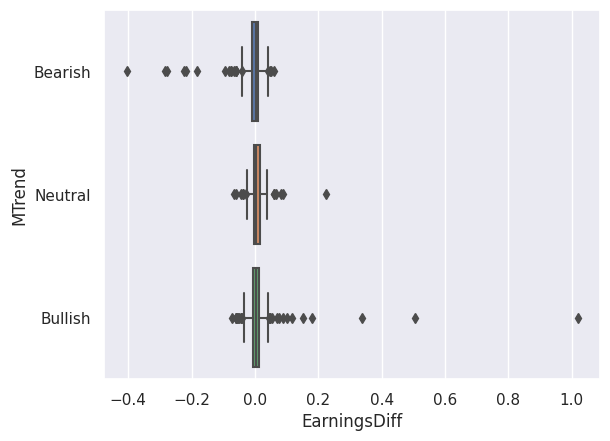

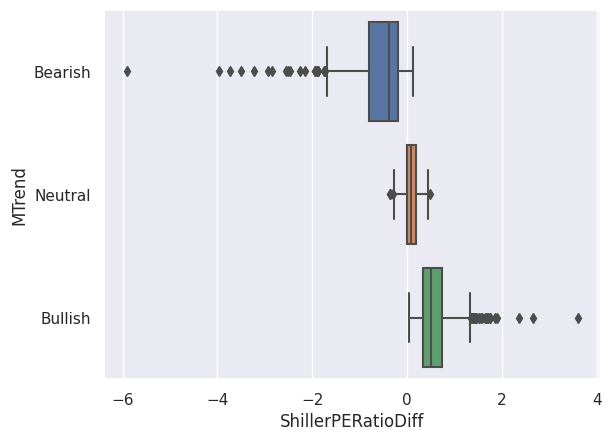

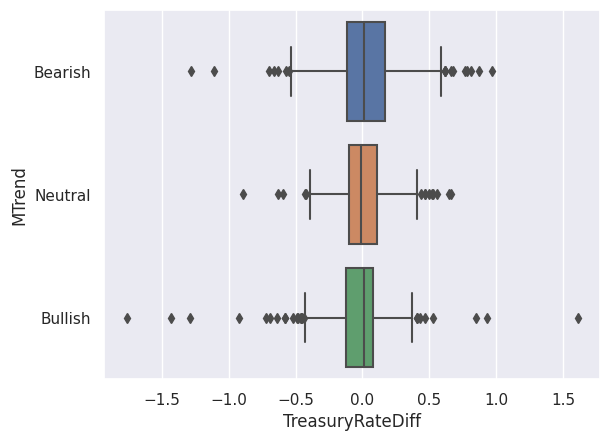

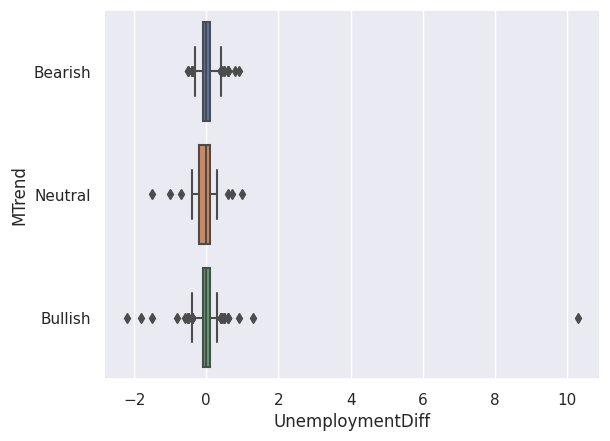

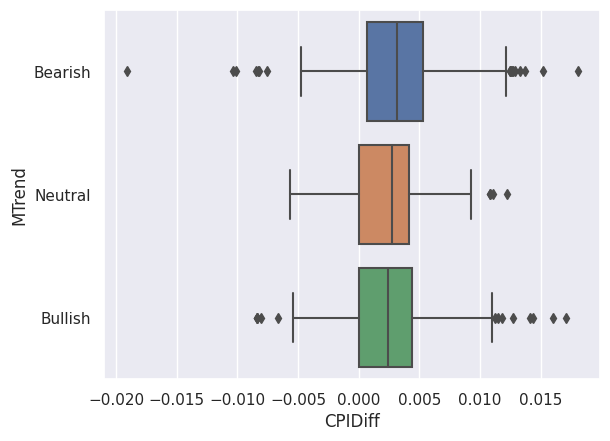

In [ ]:
# Boxplot Monthly 3 Classes Trend
for column in df_monthly_diff.iloc[:,1:7].columns:
    plt.figure()
    sns.boxplot(x = df_monthly_diff[column],
            y = df_monthly_diff['MTrend'])

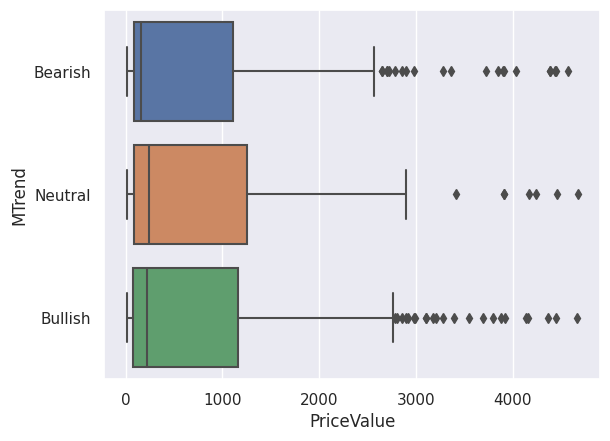

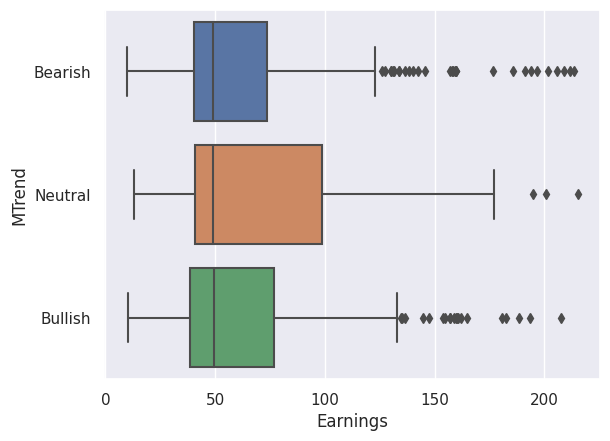

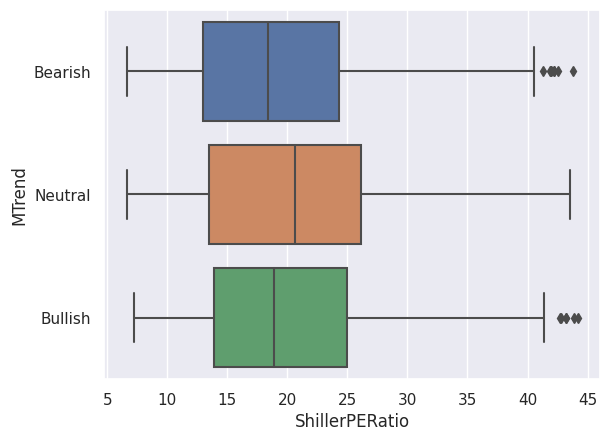

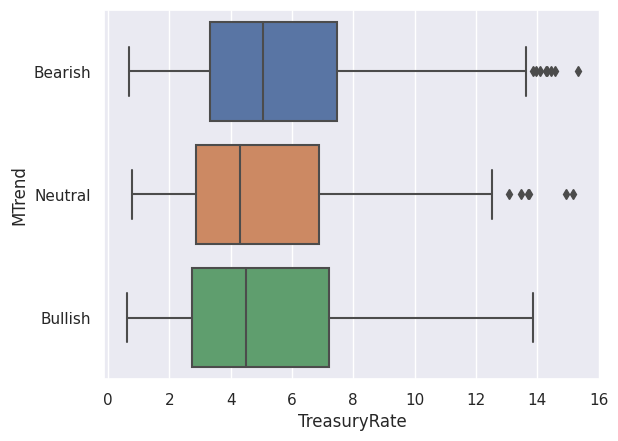

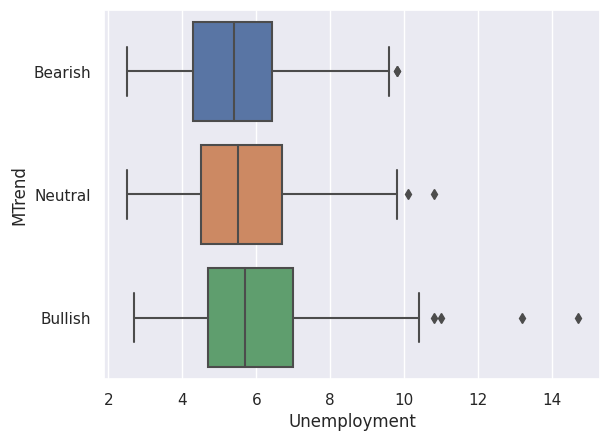

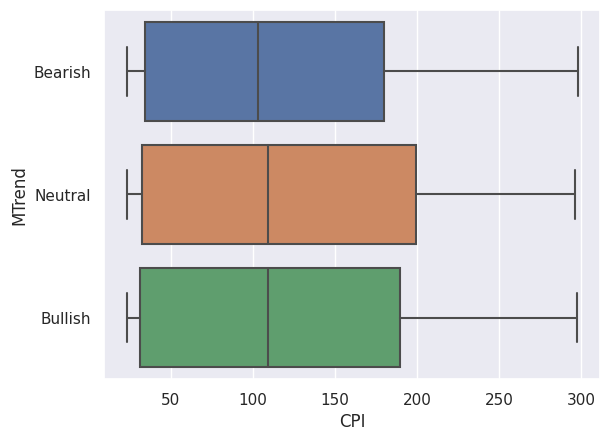

In [ ]:
# Boxplot  3 Classes Trend
for column in df_monthly.iloc[:,1:7].columns:
    plt.figure()
    sns.boxplot(x = df_monthly[column],
            y = df_monthly['MTrend'])

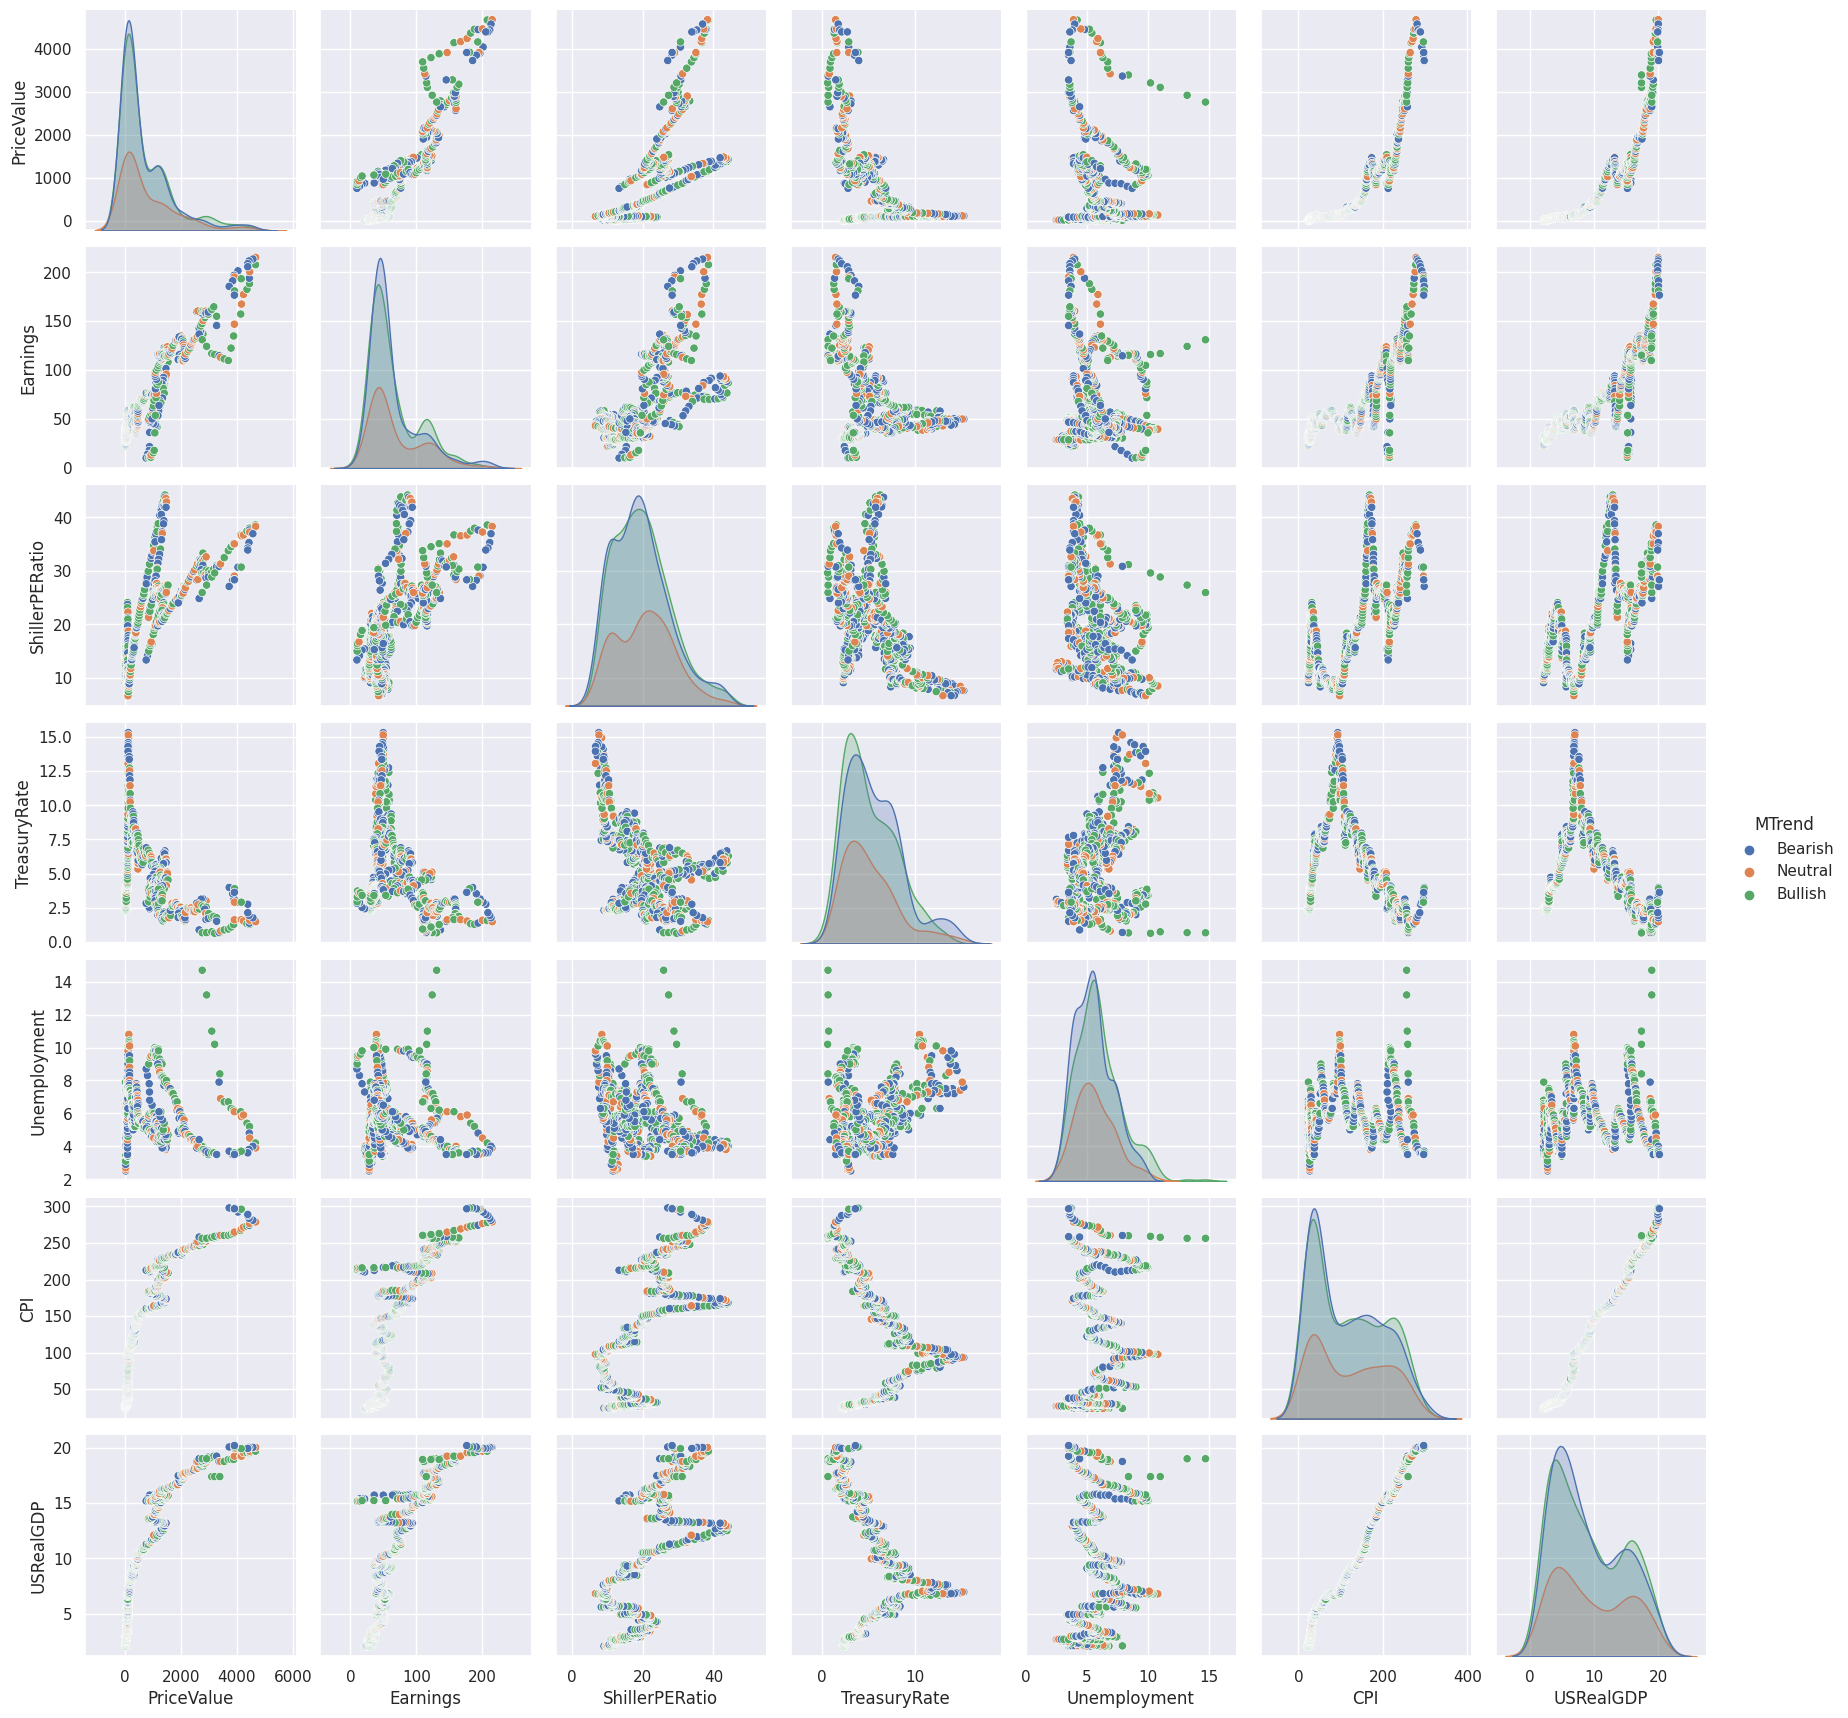

In [ ]:
sns.pairplot(data=df_monthly, kind='scatter', hue="MTrend")

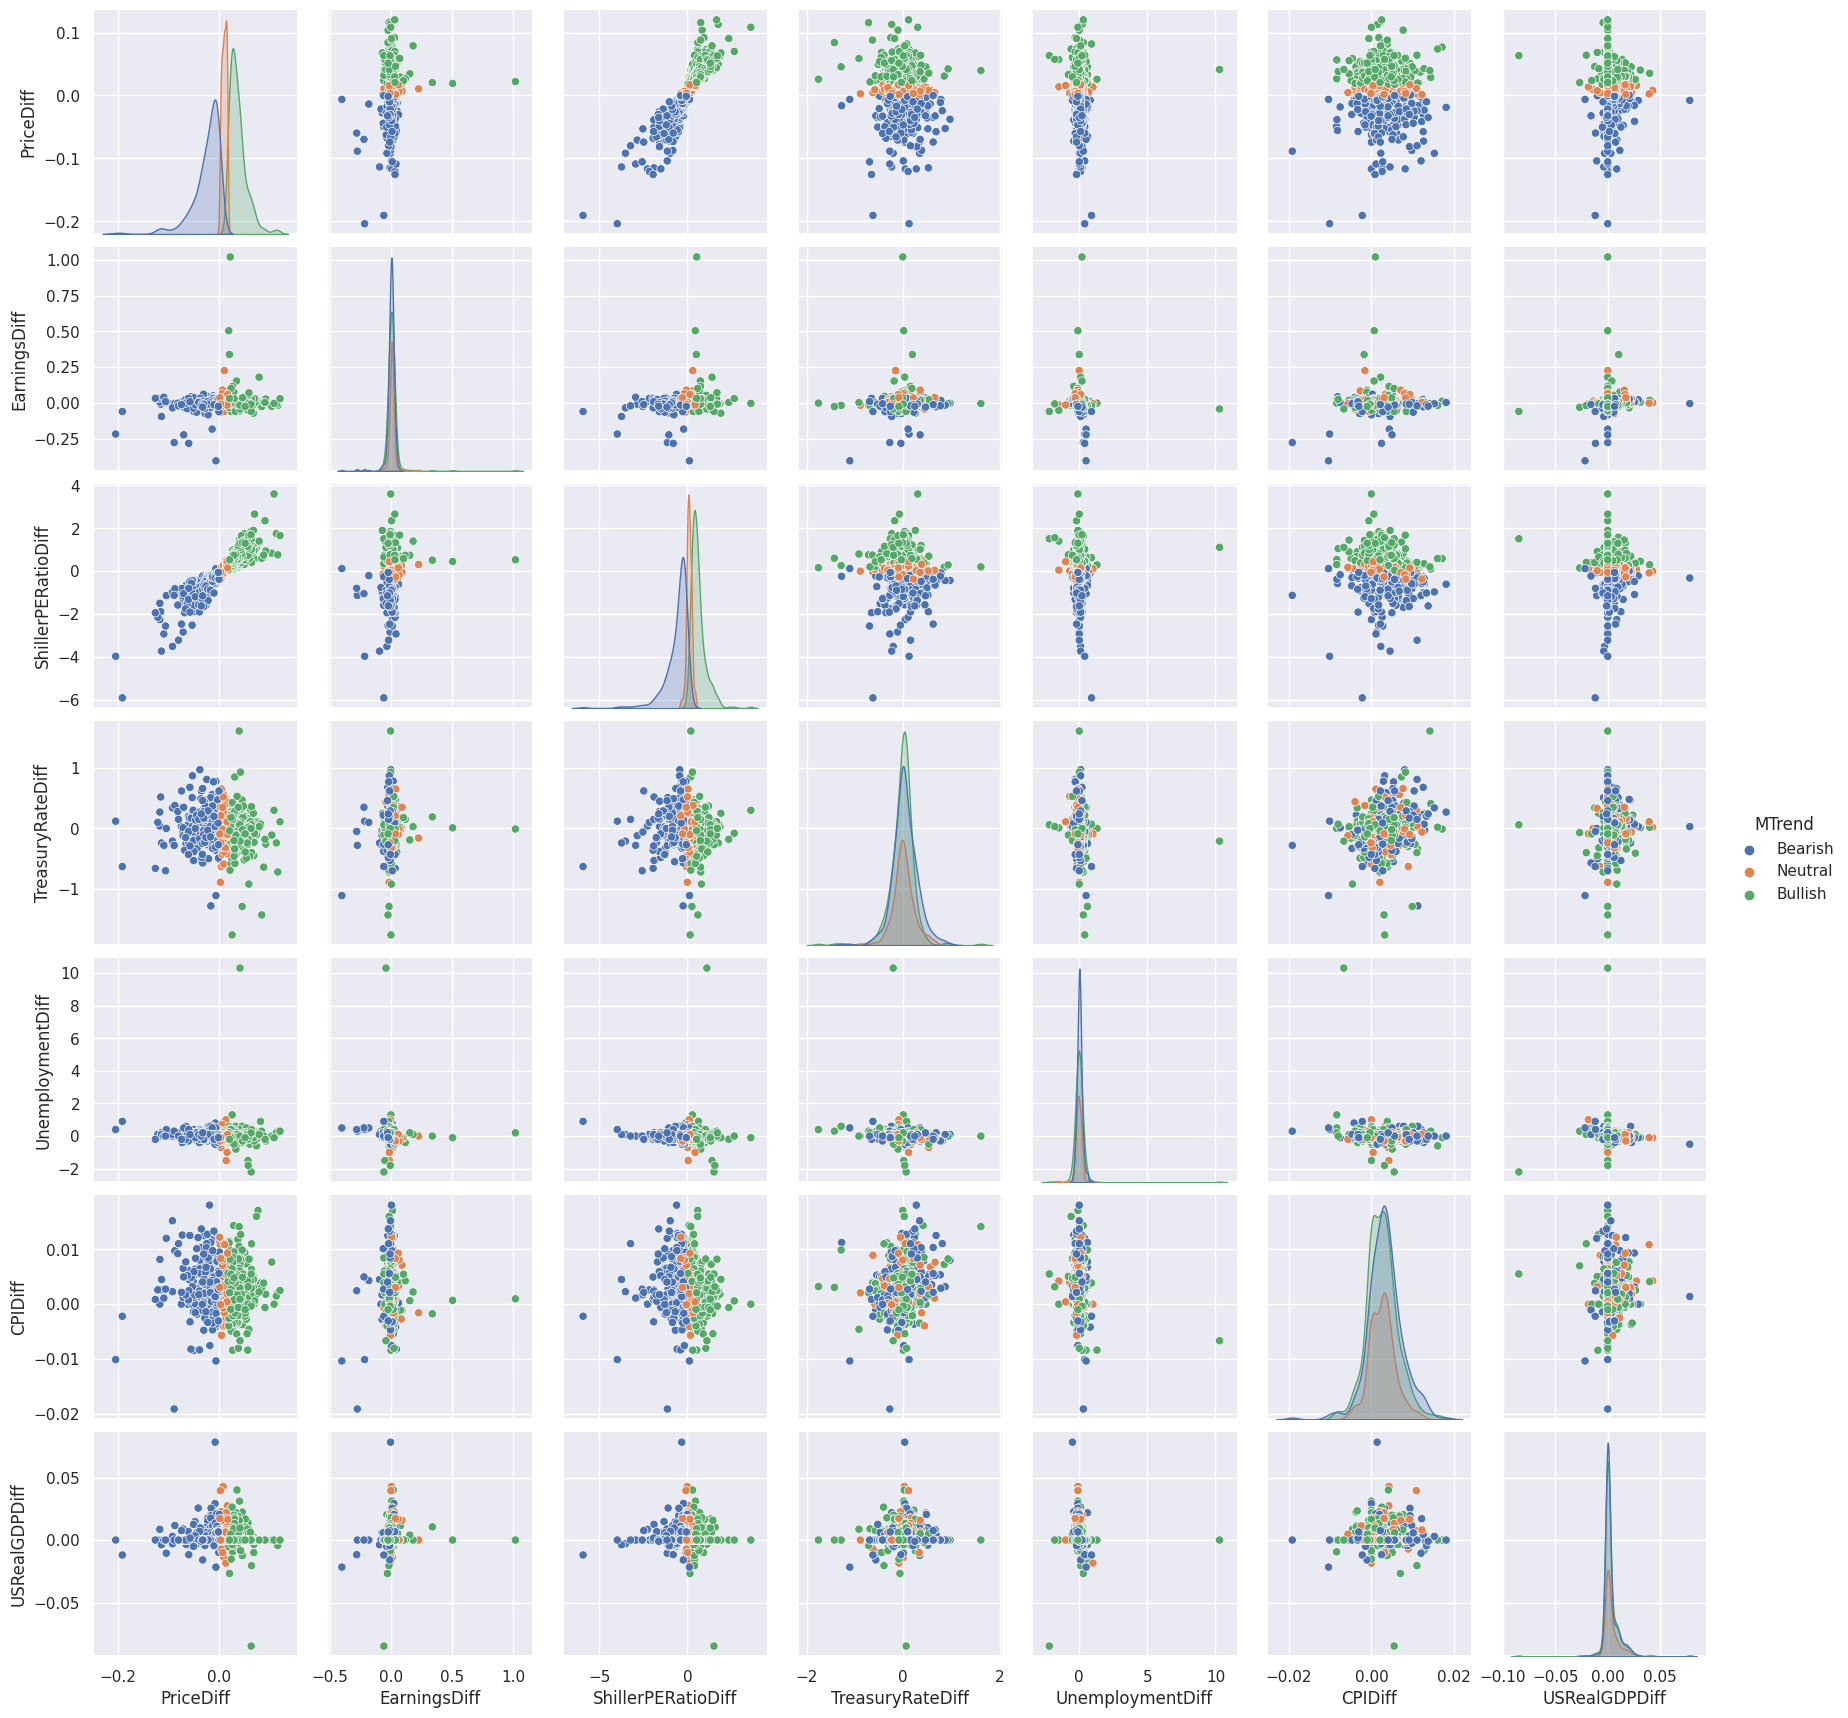

In [ ]:
sns.pairplot(data=df_monthly_diff, hue="MTrend")

# 5. Correlation - every 2 decade

In [ ]:
df_ind_mon = df_sp_raw.loc[:,['Date', 'PriceValue','PriceDiff',
       'ShillerPERatioDiff', 'EarningsDiff', 'TreasuryRateDiff',
       'UnemploymentDiff', 'CPIDiff', 'USRealGDPDiff','MTrend']]

df_ind_mon['Date'] = pd.to_datetime(df_ind_mon['Date'])

In [ ]:
# Split between 20 years
df_ind_b70 = df_ind_mon[df_ind_mon['Date']<'1970-01-01']
df_ind_b90 = df_ind_mon[(df_ind_mon['Date']>='1970-01-01') & (df_ind_mon['Date']<'1990-01-01')]
df_ind_b10 = df_ind_mon[(df_ind_mon['Date']>='1990-01-01') & (df_ind_mon['Date']<'2010-01-01')]
df_ind_b22 = df_ind_mon[df_ind_mon['Date']>='2010-01-01']

display(len(df_ind_b70),len(df_ind_b90),len(df_ind_b10),len(df_ind_b22))

263

240

240

156

<ipython-input-33-636721f4d53d>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corre70 = df_ind_b70.drop(columns = ["PriceValue"]).corr()


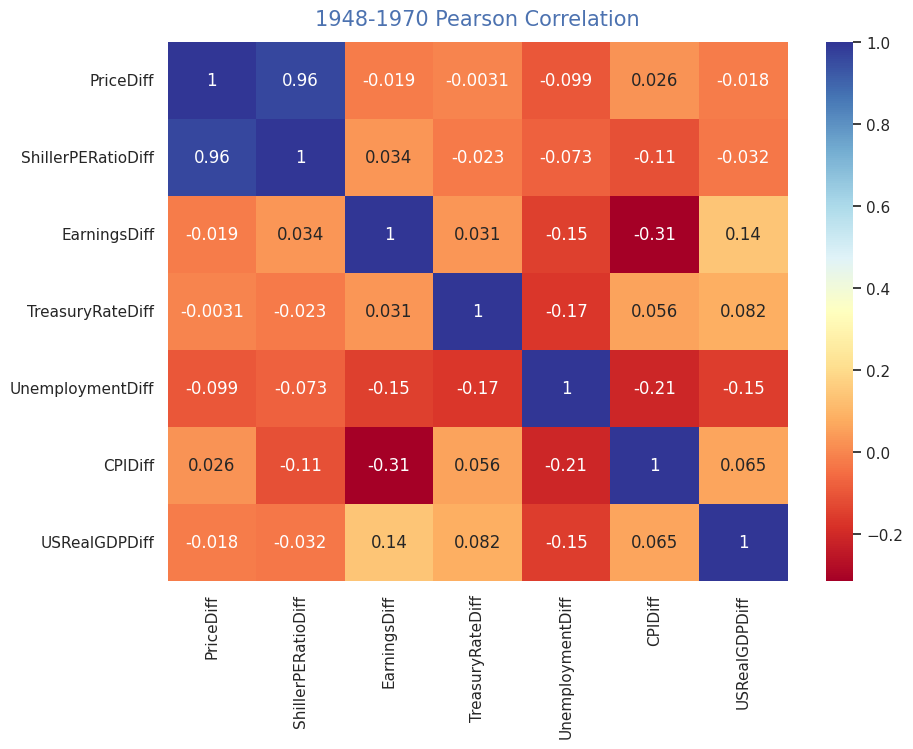

<ipython-input-33-636721f4d53d>:11: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corre90 = df_ind_b90.drop(columns = ["PriceValue"]).corr()


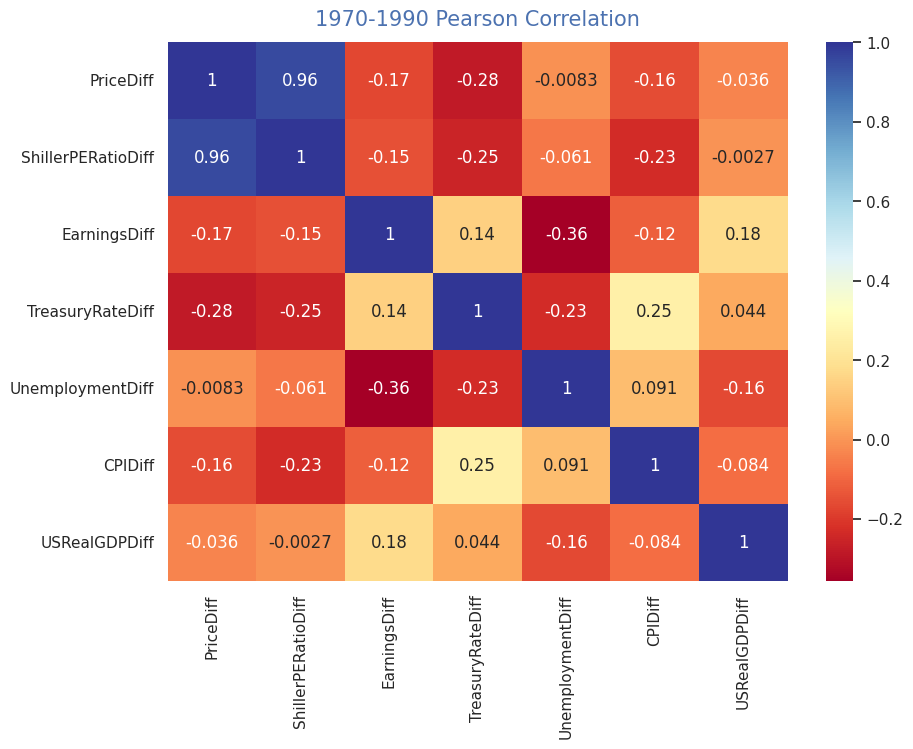

<ipython-input-33-636721f4d53d>:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corre10 = df_ind_b10.drop(columns = ["PriceValue"]).corr()


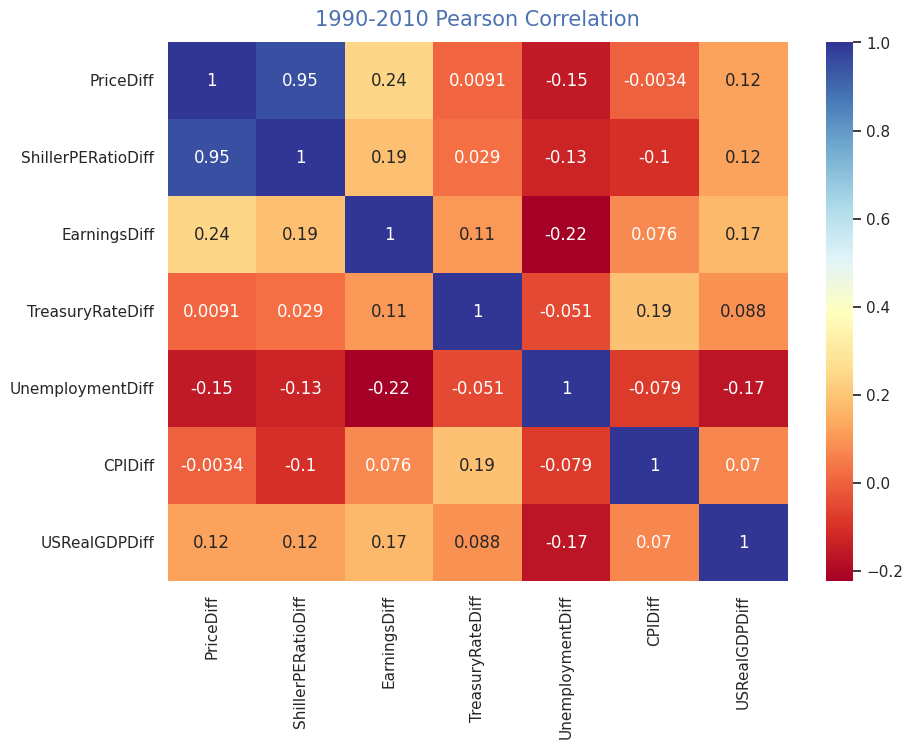

<ipython-input-33-636721f4d53d>:25: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corre22 = df_ind_b22.drop(columns = ["PriceValue"]).corr()


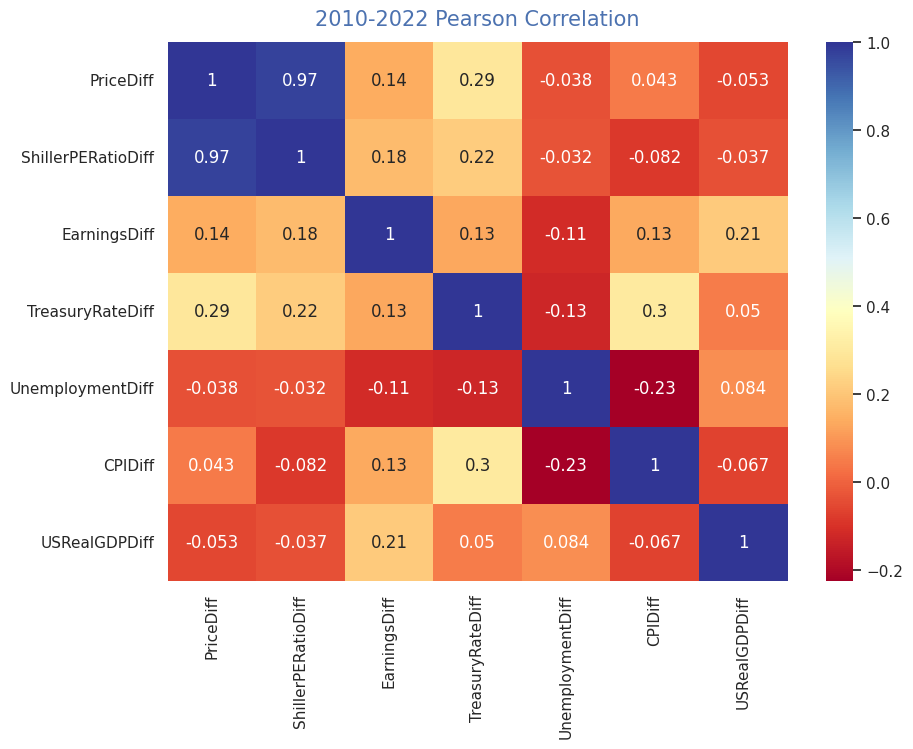

In [ ]:
# Correlation by 2-decades

## 1948-1970
corre70 = df_ind_b70.drop(columns = ["PriceValue"]).corr()
plt.figure(figsize = (10,7))
sns.heatmap(corre70, annot = True, cmap = 'RdYlBu')
plt.title("1948-1970 Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()

## 1970-1990
corre90 = df_ind_b90.drop(columns = ["PriceValue"]).corr()
plt.figure(figsize = (10,7))
sns.heatmap(corre90, annot = True, cmap = 'RdYlBu')
plt.title("1970-1990 Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()

## 1990-2010
corre10 = df_ind_b10.drop(columns = ["PriceValue"]).corr()
plt.figure(figsize = (10,7))
sns.heatmap(corre10, annot = True, cmap = 'RdYlBu')
plt.title("1990-2010 Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()

## 2010-2022
corre22 = df_ind_b22.drop(columns = ["PriceValue"]).corr()
plt.figure(figsize = (10,7))
sns.heatmap(corre22, annot = True, cmap = 'RdYlBu')
plt.title("2010-2022 Pearson Correlation", fontsize = 15, color = 'b', pad = 12, loc = 'center')
plt.show()